In [34]:
%%time

# IMPORT CSV
import pandas as pd

df = pd.read_csv('./all/train.csv', nrows=10000)

Wall time: 29 ms


In [35]:
#%%time

#SAVE AS FEATHER
#import feather

#df.to_feather('./all/train.feather')

In [36]:
#%%time

#df = pd.read_feather('./all/train.feather')

In [37]:
# CHECK FOR INVALID COORDINATES (outside of NYC range)
# determined with https://www.mapdevelopers.com/geocode_bounding_box.php

def valid_coordinates(lat_list, lon_list):
    for i in lat_list:
        if i < 40.477399 or i > 40.917577:
            return False
    for i in lon_list:
        if i < -74.259090 or i > -73.700272:
            return False
    return True

for index, row in df.iterrows():
    lat_list = [row['pickup_latitude'], row['dropoff_latitude']]
    lon_list = [row['pickup_longitude'], row['dropoff_longitude']]
    
    if not valid_coordinates(lat_list, lon_list):
        df.drop(index, inplace=True)

In [108]:
# REMOVE INVALID PASSENGER COUNTS AND FARES

df = df[df['passenger_count'] > 0]
df = df[df['fare_amount'] > 0]

In [39]:
# CALCULATE EUCLIDEAN DISTANCE

from scipy.spatial import distance

def euclidean_distance(row):
    a = (row['pickup_latitude'], row['pickup_longitude'])
    b = (row['dropoff_latitude'], row['dropoff_longitude'])
    return distance.euclidean(a, b)

df['euclidean_distance'] = df.apply(euclidean_distance, axis=1)

In [109]:
# EXTRACT DATE/TIME VALUES

df['day'] = df.apply(lambda row: pd.to_datetime(row['pickup_datetime']).day, axis=1)
df['month'] = df.apply(lambda row: pd.to_datetime(row['pickup_datetime']).month, axis=1)
df['hour'] = df.apply(lambda row: pd.to_datetime(row['pickup_datetime']).hour +\
                                 (pd.to_datetime(row['pickup_datetime']).minute / 60), axis=1)
df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,euclidean_distance,day,month,hour
0,2009-06-15 17:26:21.0000001,4.50,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.009436,15,6,17.433333
1,2010-01-05 16:52:16.0000002,16.90,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.079696,5,1,16.866667
2,2011-08-18 00:35:00.00000049,5.70,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.013674,18,8,0.583333
3,2012-04-21 04:30:42.0000001,7.70,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,0.025340,21,4,4.500000
4,2010-03-09 07:51:00.000000135,5.30,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,0.019470,9,3,7.850000
5,2011-01-06 09:50:45.0000002,12.10,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1,0.038675,6,1,9.833333
6,2012-11-20 20:35:00.0000001,7.50,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1,0.014565,20,11,20.583333
7,2012-01-04 17:22:00.00000081,16.50,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1,0.045146,4,1,17.366667
8,2012-12-03 13:10:00.000000125,9.00,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1,0.014258,3,12,13.166667
9,2009-09-02 01:11:00.00000083,8.90,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2,0.026593,2,9,1.183333


In [83]:
import matplotlib.pyplot as plt
%matplotlib inline

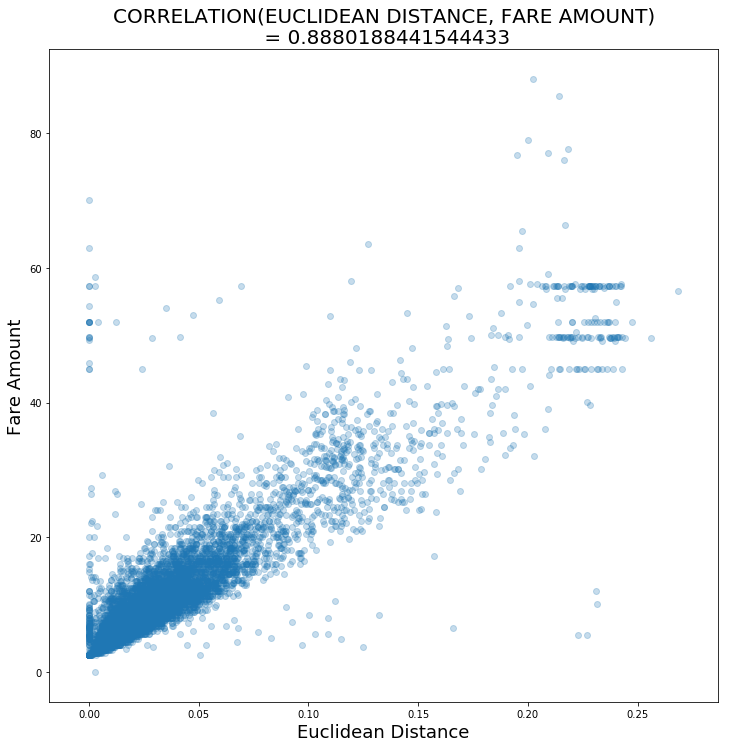

In [103]:
# CORRELATION(EUCLIDEAN DISTANCE, FARE AMOUNT)

corr = df['euclidean_distance'].corr(df['fare_amount'])
plt.figure(figsize=(12,12))
plt.scatter(df['euclidean_distance'], df['fare_amount'], alpha=0.25)
plt.title('CORRELATION(EUCLIDEAN DISTANCE, FARE AMOUNT)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Euclidean Distance', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.show()

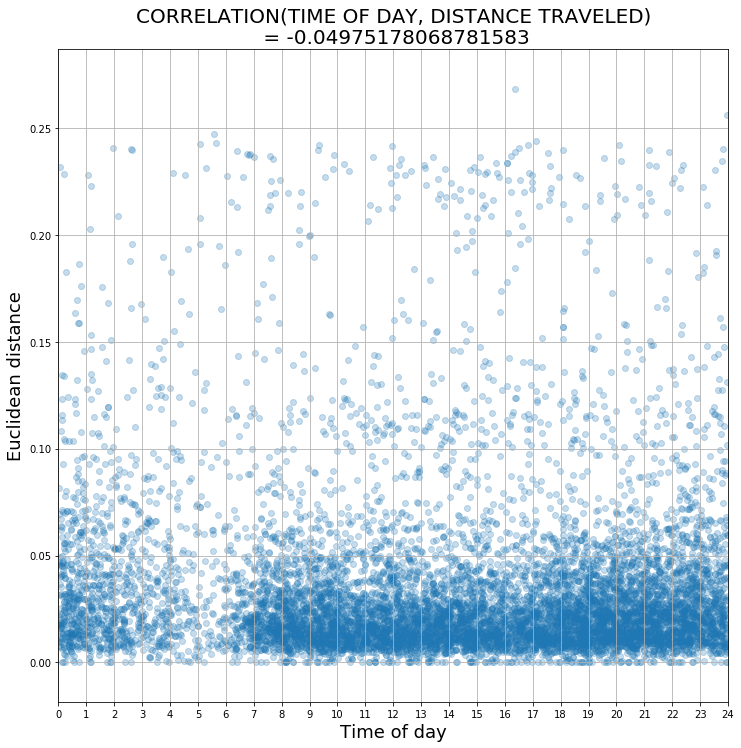

In [104]:
# CORRELATION(TIME OF DAY, DISTANCE TRAVELED)

corr = df['hour'].corr(df['euclidean_distance'])
plt.figure(figsize=(12,12))
plt.scatter(df['hour'], df['euclidean_distance'], alpha=0.25)
plt.title('CORRELATION(TIME OF DAY, DISTANCE TRAVELED)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Euclidean distance', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

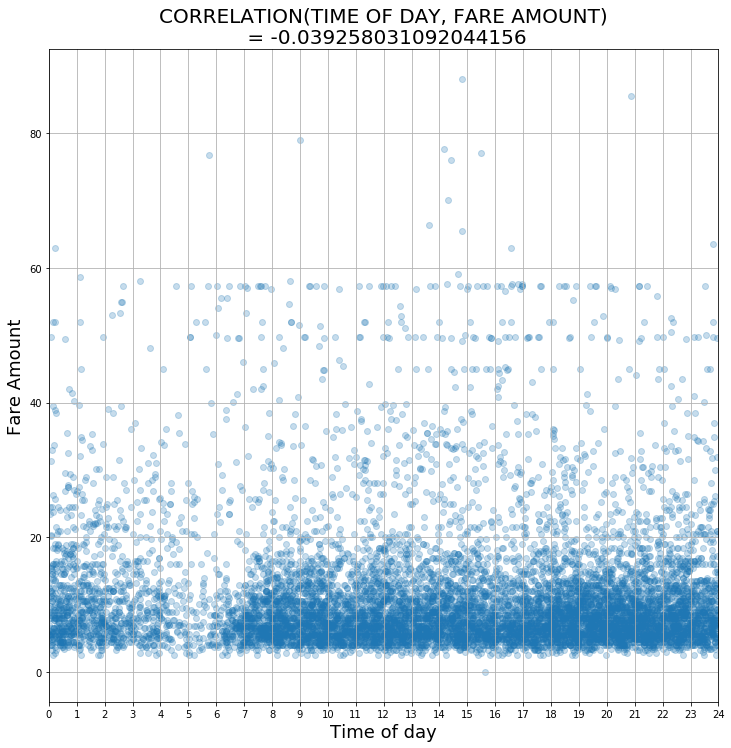

In [98]:
# CORRELATION(TIME OF DAY, FARE AMOUNT)

corr = df['hour'].corr(df['fare_amount'])
plt.figure(figsize=(12,12))
plt.scatter(df['hour'], df['fare_amount'], alpha=0.25)
plt.title('CORRELATION(TIME OF DAY, FARE AMOUNT)\n = {0}'.format(corr), fontsize = 20)
plt.xlabel('Time of day', fontsize=18)
plt.ylabel('Fare Amount', fontsize=18)
plt.xlim(0,24)
plt.xticks(range(0,25))
plt.grid(True)
plt.show()

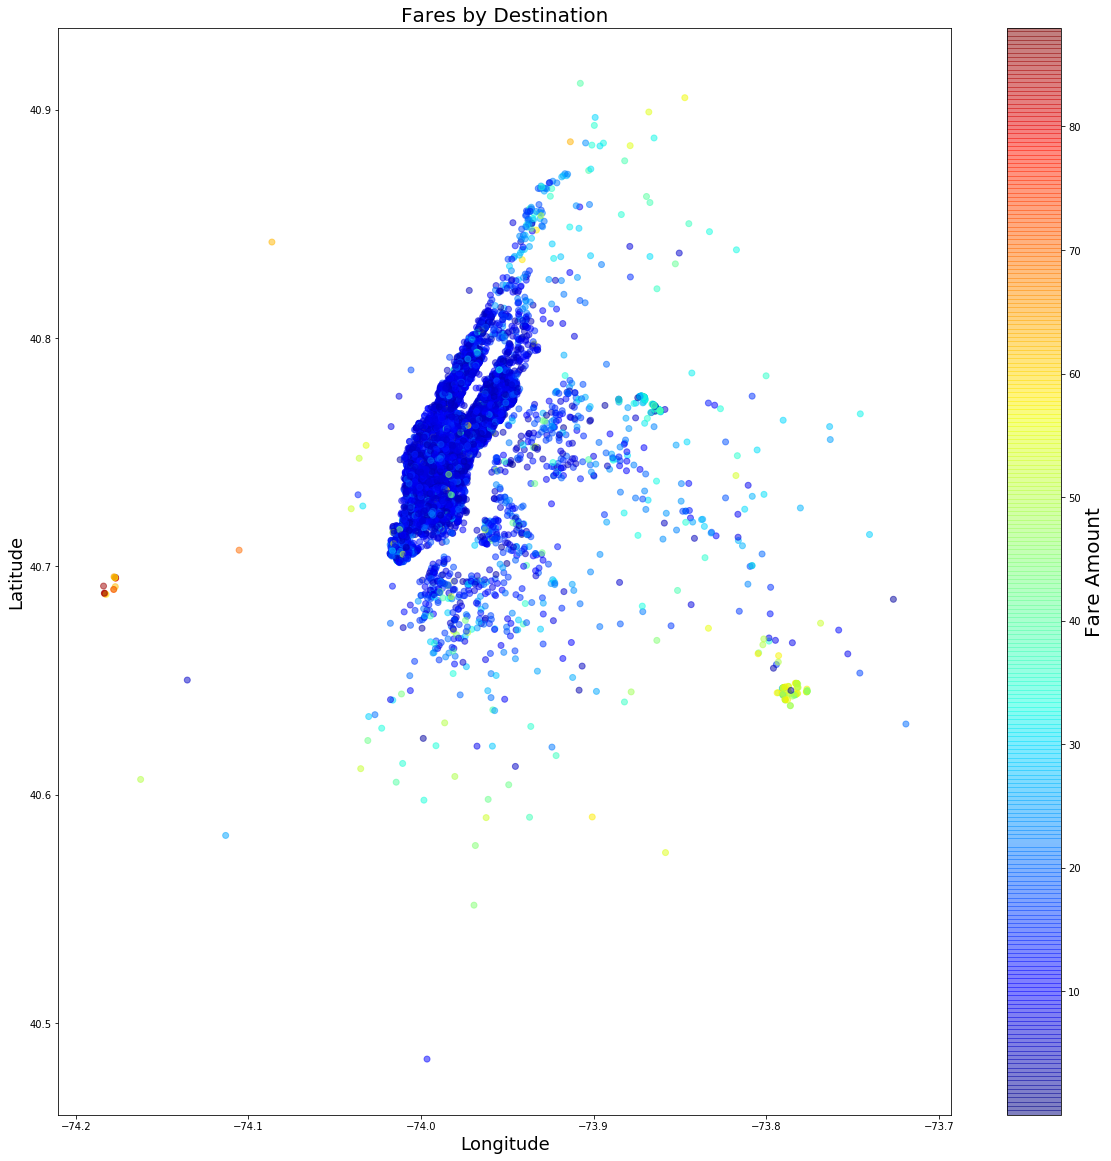

In [157]:
plt.figure(figsize=(20,20))
plt.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'], cmap=plt.get_cmap("jet"), alpha=0.5)
colorbar = plt.colorbar()
colorbar.ax.set_ylabel('Fare Amount', fontsize=20)
plt.title('Fares by Destination'.format(corr), fontsize = 20)
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.show()